In [ ]:
from tensorflow.keras.datasets import mnist
from numpy.linalg import inv,pinv,eig
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline 

In [ ]:
(x_train, y_train), (x_test, y_test)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#Q1 a
for i in range(10):
  ct=0
  j=0
  while(ct<5):
    if(y_train[j]==i):
      plt.imshow(x_train[j], cmap='binary')
      plt.show()
      ct+=1
    j+=1


In [ ]:
class DataSet:
  def __init__(self, data, targets, valid_classes=None):
    if valid_classes is None:
      self.valid_classes = np.unique(targets)
    else:
      self.valid_classes = valid_classes
    #print(self.valid_classes)
    self.number_of_classes = len(self.valid_classes)
    self.data = self.to_dict(data, targets)

  def to_dict(self, data, targets):
    data_dict = {}
    for x, y in zip(data, targets):
      if y in self.valid_classes:
        if y not in data_dict:
          data_dict[y] = [x.flatten()]
        else:
          data_dict[y].append(x.flatten())

    for i in self.valid_classes:
      data_dict[i] = np.asarray(data_dict[i])

    return data_dict

  def get_data_by_class(self, class_id):
    if class_id in self.valid_classes:
      return self.data[class_id]
    else:
      raise ("Class not found.")

  def get_data_as_dict(self):
    return self.data

  def get_all_data(self):
    data = []
    labels = []
    for label, class_i_data in self.data.items():
      data.extend(class_i_data)
      labels.extend(class_i_data.shape[0] * [label])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [ ]:

class QDAClassifier:
  
  def __init__(self, projection_dim):
    self.projection_dim = projection_dim
    self.W = None # weights
    self.X = None # weights
    
    self.g_means, self.g_covariance, self.priors = None, None, None
  #Q1b
  def fit(self,X):
    means_k = self.__compute_means(X)

    Sks = []
    for class_i, m in means_k.items():
      sub = np.subtract(X[class_i], m)
      Sks.append(np.dot(np.transpose(sub), sub))

    Sks = np.asarray(Sks)
    Sw = np.sum(Sks, axis=0) # shape = (D,D)

    Nk = {}
    sum_ = 0
    for class_id, data in X.items():
      Nk[class_id] = data.shape[0]
      sum_ += np.sum(data, axis=0)
    print(Nk.values())
    self.N=0
    for i in Nk.values():
      self.N+=i
    
    m = sum_ / self.N

    SB = []
    for class_id, mean_class_i in means_k.items():
      sub_ = mean_class_i - m
      SB.append(np.multiply(Nk[class_id], np.outer(sub_, sub_.T)))
    
    SB = np.sum(SB, axis=0)  # sum of K (# of classes) matrices
    matrix = np.dot(pinv(Sw), SB)
    eigen_values, eigen_vectors = eig(matrix)
    print("eigen_values:", eigen_values.shape)
    print("eigen_vectors:", eigen_vectors.shape)

    eiglist = [(eigen_values[i], eigen_vectors[:, i]) for i in range(len(eigen_values))]

    eiglist = sorted(eiglist, key=lambda x: x[0], reverse=True)

    self.W = np.array([eiglist[i][1] for i in range(self.projection_dim)])
    self.W = np.asarray(self.W).T
    print(self.W)
  
  def __compute_means(self, X):
    means_k = {}
    for class_i, input_vectors in X.items():
      means_k[class_i] = np.mean(input_vectors, axis=0)
    return means_k
  #Q1c
  def showprojected(self, inputs):
    self.X= np.matmul(inputs, self.W)#projected_data
    print(self.X.shape)
    print(self.X[0][0])
    
  def gaussian(self, X):
    means = {}
    covariance = {}
    priors = {}  # p(Ck)
    for class_id, values in X.items():
      proj = np.dot(values, self.W)
      means[class_id] = np.mean(proj, axis=0)
      covariance[class_id] = np.cov(proj, rowvar=False)
      priors[class_id] = values.shape[0] / self.N
    return means, covariance, priors
  #Q1d
  def QDA(self, means, cov,priors, targets):
    ct=0
    myclass=-1
    mydis=0
    b=0
    for inp,tgt in zip(self.X,targets):
      #if(b==10):
      #  print(ct)
      #  return 
      for i in range(10):
        
        class_mean=np.matrix(means[i])
        class_cov=np.matrix(cov[i])
        #print(class_cov)
        #print()
        x=np.matrix(inp)
        covdet=np.linalg.det(class_cov)
        #print(covdet)
        
        if(covdet!=0):
          covinv= inv(class_cov)
          meanmat=np.matrix(means[i])
          priormat=np.matrix(priors[i])
          t1 = x*class_cov*np.transpose(x)
          t2 = 2*meanmat*covinv*np.transpose(x)
          t3 = meanmat*covinv*meanmat.T
          gi=np.log(1/np.sqrt(covdet)) - 1/2*(t1-t2+t3) + np.log(priormat)
          #print(gi)
          if(gi>mydis):
            mydis=gi
            myclass=i
      #print(myclass)
      #print(tgt)
      #print() 
      if(myclass==tgt):
        ct+=1
      #b+=1
    print(ct)
    return ct



In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0
train_dataset = DataSet(x_train, y_train)
inputs, targets = train_dataset.get_all_data()

print(inputs.shape,targets.shape)

clf = QDAClassifier(projection_dim=9)
clf.fit(train_dataset.get_data_as_dict())

#acc = clf.score(inputs,targets)[0]
#print("Train acc:", acc)

(60000, 784) (60000,)
dict_values([5421, 5923, 5842, 6742, 5949, 5958, 6131, 5918, 6265, 5851])
eigen_values: (784,)
eigen_vectors: (784, 784)
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [ ]:
clf.showprojected(inputs)

(60000, 9)
(0.009159458786770594+0j)


In [ ]:
means,cov,prior=clf.gaussian(train_dataset.get_data_as_dict())

In [ ]:
accu=clf.QDA(means, cov,prior, targets)

6742


In [ ]:
print(accu/10000)

0.6742


In [ ]:
#train_dataset.get_data_as_dict()

In [ ]:
#means,cov=clf.gaussian(train_dataset.get_data_as_dict())
#print(means)
#print()
#print(cov)

In [ ]:
test_dataset = DataSet(x_test, y_test)
inputs, targets = test_dataset.get_all_data()

#acc = clf.score(inputs,targets)
#print("Test acc:", acc)

In [ ]:
#2a
a=0
b=10
X_train = np.random.uniform(a,b,5)
var=(b-a)*(b-a+2)/12
X_train

array([5.20559863, 9.60327113, 1.30836356, 5.18062716, 3.87771683])

In [ ]:
Y_train = X_train*np.exp(X_train)
Y_train

array([9.48928384e+02, 1.42254774e+05, 4.84109403e+00, 9.21085885e+02,
       1.87347160e+02])

In [ ]:
k=[]
for i in range(5):
  arr=[]
  for j in range(5):
    arr.append(var*np.exp(-np.square(X_train[i]-X_train[j])))
  k.append(arr)
k

[[10.0,
  3.989805210639249e-08,
  2.533633732357086e-06,
  9.99376620352397,
  1.7148318548837118],
 [3.989805210639249e-08,
  10.0,
  1.3126674999777046e-29,
  3.201073404710148e-08,
  5.793892815307393e-14],
 [2.533633732357086e-06,
  1.3126674999777046e-29,
  10.0,
  3.0761237712057888e-06,
  0.013582255054933852],
 [9.99376620352397,
  3.201073404710148e-08,
  3.0761237712057888e-06,
  10.0,
  1.831270088696969],
 [1.7148318548837118,
  5.793892815307393e-14,
  0.013582255054933852,
  1.831270088696969,
  10.0]]

In [ ]:
# var=1 and l=1
#Q2b1
var=1
l=1
sum=0
for test in range(5):
  k=[]
  for i in range(5):
    if i==test:
      continue
    arr=[]
    for j in range(5):
      if j==test:
        continue
      arr.append(var*np.exp(-np.square(X_train[i]-X_train[j])/(2*l*l)))
    k.append(arr)

  kst=[]
  for i in range(5):
    if i==test:
      continue
    #print(var*np.exp(-np.square(X_train[i]-X_train[test])))
    kst.append(var*np.exp(-np.square(X_train[i]-X_train[test])/(2*l*l)))
  #print()
  y=[]
  for i in range(5):
    if i==test:
      continue
    y.append(Y_train[i])
  
  kst=np.matrix(kst)
  y=np.matrix(y)
  mu=kst*inv(k)*np.transpose(y)
  sum+=(mu[0][0]-Y_train[test])*(mu[0][0]-Y_train[test])
print(np.sqrt(sum/5))
  

[[63618.3150847]]


In [ ]:
#Q2b2
var=0
mini=100000
while var<100:
  L=1
  while L<100:
    sum=0
    for test in range(5):
      k=[]
      for i in range(5):
        if i==test:
          continue
        arr=[]
        for j in range(5):
          if j==test:
            continue
          arr.append(var*np.exp(-np.square(X_train[i]-X_train[j])/(2*L*L)))
        k.append(arr)
      kst=[]
      for i in range(5):
        if i==test:
          continue
        #print(var*np.exp(-np.square(X_train[i]-X_train[test])))
        kst.append(var*np.exp(-np.square(X_train[i]-X_train[test])/(2*L*L)))
      #print()
      y=[]
      for i in range(5):
        if i==test:
          continue
        y.append(Y_train[i])
      
      kst=np.matrix(kst)
      y=np.matrix(y)
      mu=0
      if(np.linalg.det(k)):
        mu=kst*inv(k)*np.transpose(y)
      sum+=(mu-Y_train[test])*(mu-Y_train[test])
    #print(var, " ", L, " ", np.sqrt(sum/5))
    if np.sqrt(sum/5)<mini : 
      mini=np.sqrt(sum/5)
      myvar=var
      myL=L
    L+=1
  var+=1

print(myL)
print(myvar)
print(mini)

    

98
69
[[56408.8818566]]


In [ ]:
#2c
a=0
b=10
X_test = np.random.uniform(a,b,50)
var=(b-a)*(b-a+2)/12
X_test

array([5.69214823, 7.94032564, 0.41738338, 9.61934788, 3.61228908,
       2.80152379, 7.44789177, 2.14604236, 3.09424427, 4.12522372,
       9.15070239, 4.72946719, 5.54074592, 2.03470556, 0.58229027,
       9.00918485, 7.91553248, 4.98429936, 1.8865333 , 3.22700409,
       0.76015165, 4.38912258, 1.1593877 , 2.80140729, 9.58897663,
       2.64860875, 3.10027638, 9.10989633, 4.88158351, 0.16938418,
       5.60355402, 2.61971479, 3.24762812, 7.36750773, 9.13379671,
       1.41490913, 4.87790247, 2.56051152, 1.15887289, 3.42915685,
       0.39147442, 6.4319324 , 6.2173625 , 5.82643062, 5.39594582,
       4.34077573, 3.23772634, 4.82732136, 4.2973916 , 1.71682424])

In [ ]:
Y_test = X_test*np.exp(X_test)
Y_test

array([1.68789243e+03, 2.22986167e+04, 6.33581442e-01, 1.44802259e+05,
       1.33838085e+02, 4.61403240e+01, 1.27823780e+04, 1.83507004e+01,
       6.82916816e+01, 2.55275660e+02, 8.62092737e+04, 5.35542227e+02,
       1.41215906e+03, 1.55654961e+01, 1.04237740e+00, 7.36757834e+04,
       2.16846399e+04, 7.28211989e+02, 1.24444434e+01, 8.13335236e+01,
       1.62566073e+00, 3.53630267e+02, 3.69610560e+00, 4.61330302e+01,
       1.40027036e+05, 3.74363910e+01, 6.88388075e+01, 8.23931565e+04,
       6.43584396e+02, 2.00648296e-01, 1.52074415e+03, 3.59734169e+01,
       8.35590056e+01, 1.16677886e+04, 8.46074980e+04, 5.82392508e+00,
       6.40736165e+02, 3.31392564e+01, 3.69256295e+00, 1.05791615e+02,
       5.79053345e-01, 3.99663255e+03, 3.11725561e+03, 1.97601049e+03,
       1.18986331e+03, 3.33228620e+02, 8.24834504e+01, 6.02816649e+02,
       3.15891827e+02, 9.55725403e+00])

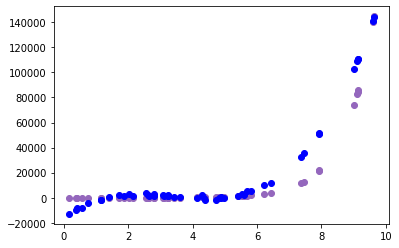

In [ ]:
#2d
sum=0
xs=[]
ys=[]
for test in range(50):
  k=[]
  for i in range(5):
    arr=[]
    for j in range(5):
      arr.append(myvar*np.exp(-np.square(X_train[i]-X_train[j])/(2*myL*myL)))
    k.append(arr)

  kst=[]
  for i in range(5):
    kst.append(myvar*np.exp(-np.square(X_train[i]-X_test[test])/(2*myL*myL)))
  y=[]
  for i in range(5):
    y.append(Y_train[i])
  
  kst=np.matrix(kst)
  y=np.matrix(y)
  mu=kst*inv(k)*np.transpose(y)
  temp=mu.item(0,0)
  xs.append(temp)
  
#2e
plt.scatter(X_test,Y_test, c='#9467bd')
plt.scatter(X_test,xs, c='b')
plt.show()



In [ ]:
#Q3
#b
mean = [0,0]
cov = [[0.2, 0.5],[0.5, 0.2]]
X= np.random.multivariate_normal(mean, cov, 100)
X_train=X[0:50]
X_test=X[50:100]

Y=np.random.multivariate_normal([1],[[0.5]],size=100)
Y_train=Y[0:50]
Y_test=Y[50:100]

LR=0.001   
b1=2
b2=2
b3=2
b0=2
B_star=0.2

#c
def sig(val):
    res=1/(1+np.exp(-val))
    return res

def forward(X):
    a1=b1*X[0]+b2*X[1]+b0
    z1=sig(a1)
    a2=b3*z1+B_star
    z2=sig(a2)
    return a1,a2,z1,z2

def update(X,Y):
    a1,a2,z1,z2=forward(X)
    y_hat=z2 #predicted value
    Error=(Y-y_hat)**2
    b0_star=b0-LR*(-2*(Y-z2)*sig(a2)*(1-sig(a2))*b3*sig(a1)*(1-sig(a1)))
    b1_star=b1-LR*(-2*(Y-z2)*sig(a2)*(1-sig(a2))*b3*sig(a1)*(1-sig(a1))*X[0])
    b2_star=b2-LR*(-2*(Y-z2)*sig(a2)*(1-sig(a2))*b3*sig(a1)*(1-sig(a1))*X[1])
    b3_star=b3-LR*(-2*(Y-z2)*sig(a2)*(1-sig(a2))*z1)
    return b1_star,b2_star,b3_star,b0_star

#d
epoch=5
for i in range(epoch):
    for data,label in zip(X_train,Y_train):
        b1,b2,b3,bo=update(data,label)
#e
Y_pred=[]
for test_data,test_label in zip(X_test,Y_test):
    a1,a2,z1,z2=forward(test_data)
    Y_pred.append(z2)

a=Y_test-Y_pred

#print(a)
mean=[]
sum=0
for i in range(50):
  sum+=a[i]*a[i]
print(sum/100)

[0.31292223]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """
